In [19]:
import tracemalloc
import pickle
from typing import List, Dict, Any, Callable
from time import time
from tqdm import tqdm


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", context="talk")

from utils import Solution, Problem, Minimize, Maximize, ObjectiveFunction
from heuristics import HillClimbing

# 1. Solução

As soluções do problema de alocação de empresas à projetos estão modeladas na classe `Solution`, que é construída a partir de dois parâmetros:

- `n_companies`: o número de empresas a ser modelado;
- `n_projects`: o número de projetos a ser modelado.

De posse dessas duas informações, é criado então um atributo `x`, um array do Numpy que armazena os valores da solução codificada. Essa codificação transforma a matriz esparsa $m \times n$ em um array 1-D cujos índices e valores indicam a linha e coluna de posição de uma alocação, respectivamente. Dessa forma, a restrição de ter apenas um projeto alocado a somente uma empresa é obedecida sempre.

De forma a facilitar a visualização da solução baseada em alocações empresa $\times$ projeto, o método `sparse()` retorna um array 2-D com a matriz original da codificação.

Por fim, a função de vizinhança é implementada no método `move()`, que escolhe aleatoriamente dois índices da solução e realiza a troca entre os valores, resultando assim em uma solução vizinha a anterior.

A execução a seguir demonstra a criação de uma solução que considera 9 empresas e 9 projetos, mostrando suas versões densa e esparsa, assim como é realizada a movimentação para uma solução vizinha.


In [2]:
solution = Solution(n_companies=9, n_projects=9)

print("Initial solution: ")
print(solution)
print(solution.sparse())

solution.move()

print("\nNeighbor solution: ")
print(solution)
print(solution.sparse())

Initial solution: 
[1 7 6 8 3 2 9 5 4]
[[1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]]

Neighbor solution: 
[1 5 6 8 3 2 9 7 4]
[[1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0]]


# 2. Função objetivo

Antes de definir a função objetivo, é importante armazenar a matriz de custos `cost_matrix`, que armazena os custos que cada empresa teria ao executar cada projeto, considerando a disposição dos índices como referência em relação às soluções geradas.

In [3]:
cost_matrix = np.array([
    [12, 18, 15, 22, 9, 14, 20, 11, 17],
    [19, 8, 13, 25, 16, 10, 7, 21, 24],
    [6, 14, 27, 10, 12, 19, 23, 16, 8],
    [17, 11, 20, 9, 18, 13, 25, 14, 22],
    [10, 23, 16, 14, 7, 21, 12, 19, 15],
    [13, 25, 9, 17, 11, 8, 16, 22, 20],
    [21, 16, 24, 12, 20, 15, 9, 18, 10],
    [8, 19, 11, 16, 22, 17, 14, 10, 13],
    [15, 10, 18, 21, 13, 12, 22, 9, 16]
])

A função objetivo para o problema de alocação de empresas à projetos foi modelada na classe `ObjectiveFunction`, que recebe como parâmetro uma matriz de custos. O objeto instanciado pode então ser chamado, com a passagem de uma nova solução como parâmetro, calculando assim o custo da solução.

A execução a seguir demonstra o uso da função objetivo, calculando o custo para uma solução inicial e uma solução vizinha.

In [4]:
objective_function = ObjectiveFunction(cost_matrix)

initial_cost = objective_function(solution)
print(f"Initial cost: {initial_cost}")

solution.move()

new_cost = objective_function(solution)
print(f"New cost: {new_cost}")

Initial cost: 147
New cost: 141


# 3. Problema

As considerações de um problema de otimização foram modeladas em uma superclasse `Problem`, um esboço para a implementação das classes que de fato definem o problema, `Minimize` e `Maximize`. Ao instanciar um desses tipos de problema, o objeto fica disponível para computar a condição de melhoria de custos de qualquer algoritmo de otimização ao retornar um booleano que responda ao problema, bastando passar os seguintes parâmetros:

- `new_cost`: novo custo alcançado por uma solução vizinha à atual;
- `best_cost`: melhor custo encontrado pelo algoritmo até o momento.

A execução a seguir demonstra o uso da classe para um problema de minimização.

In [5]:
problem = Minimize()
problem(new_cost=71, best_cost=72)

True

# 4. Heurísticas

## 4.1. Hill Climbing

O algoritmo Hill Climbing foi implementado na classe `HillClimbing`. Esta recebe 5 parâmetros na sua construção:

- `problem`: o tipo de problema modelado, podendo ser `Minimize` ou `Maximize`;
- `objective_function`: a função objetivo que retorna os custos de uma solução;
- `cost_matrix`: o array de custos usado na criação da função objetivo;
- `max_iterations`: condição de parada que indica o número máximo de interações que o algoritmo pode executar;
- `patience`: condição de parada que indica o número máximo de interações sem melhoria que o algoritmo pode executar.

Ao chamar o método `run()` o algoritmo é executado para uma solução inicial aleatória. Após chamar este método, não é possível realizar outra chamada, preservando assim a configuração dos resultados alcançados.

O algoritmo para quando alcança o número de iterações máximo ou quando passa um dado número de interações sem melhorar o custo, alcançando assim uma convergência local ou global.

O objeto gerado e modificado após a execução do método `run()` possui três atributos de interesse para a análise do desempenho do algoritmo:

- `n_iterations`: o valor do contador de iterações em que o algoritmo alcançou uma condição de parada, podendo ser um valor entre `patience` e `max_iterations`. Caso seja igual a `max_iterations`, é um indício de que podem ser encontrados resultados melhores, caso a quantidade de `max_iterations` aumente;
- `best_cost`: o melhor custo encontrado, após `n_iterations` iterações;
- `best_solution`: a melhor solução encontrada, cujos valores são armazenados no atributo `x`, ou em formato de matriz pelo método `sparse()`.

In [6]:
hc = HillClimbing(
    problem=Minimize(),
    objective_function=objective_function,
    cost_matrix=cost_matrix,
    max_iterations=100_000,
    patience=100
)

hc.run()

hc

Iteration: 100000

Best cost: 79

Best solution: [6 5 2 9 3 8 4 7 1]

Allocation:
[[0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0]]

# 5. Análise do comportamento médio

In [ ]:
n_runs = 100

results = []

data = {
    "iteration": [],
    "best_cost": [],
    "best_solution": [],
    "history_cost": [],
    "history_solution": [],
    "execution_time": [],
    "memory_peak": []
}

for i in tqdm(range(n_runs), desc="Running Hill Climbing"):
    hc = HillClimbing(
        problem=Minimize(),
        objective_function=objective_function,
        cost_matrix=cost_matrix,
        max_iterations=100_000,
        patience=100
    )

    start_time = time()
    tracemalloc.start()
    hc.run()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_time = time()

    results.append(hc)

    data["iteration"].append(hc.n_iterations)
    data["best_cost"].append(hc.best_cost)
    data["best_solution"].append(hc.best_solution)
    data["history_cost"].append(hc.history["best_cost"])
    data["history_solution"].append(hc.history["best_solution"])
    data["execution_time"].append(end_time - start_time)
    data["memory_peak"].append(peak)

df = pd.DataFrame(data)
df["history_cost"] = df["history_cost"].apply(lambda x: np.array(x))
df["history_solution"] = df["history_solution"].apply(lambda x: np.array(x))
df["memory_peak_mb"] = df["memory_peak"].apply(lambda x: x / 10**6)
df

,iteration,best_cost,best_solution,history_cost,history_solution,execution_time,memory_peak,memory_peak_mb
0,100000,81,[5 4 1 7 8 3 9 2 6],"[150, 150, 149, 137, 129, 128, 128, 128, 128, ...","[[5 4 1 7 8 3 9 2 6], [5 4 1 7 8 3 9 2 6], [5 ...",2.529101,1607057,1.607057
1,100000,81,[1 3 2 7 8 4 9 5 6],"[148, 144, 144, 142, 128, 128, 115, 113, 113, ...","[[1 3 2 7 8 4 9 5 6], [1 3 2 7 8 4 9 5 6], [1 ...",2.533617,1606492,1.606492
2,100000,79,[7 6 1 9 2 8 4 5 3],"[130, 130, 130, 130, 122, 122, 122, 122, 122, ...","[[7 6 1 9 2 8 4 5 3], [7 6 1 9 2 8 4 5 3], [7 ...",2.517381,1607391,1.607391
3,100000,81,[7 3 8 5 9 4 1 2 6],"[122, 122, 122, 122, 122, 120, 120, 120, 120, ...","[[7 3 8 5 9 4 1 2 6], [7 3 8 5 9 4 1 2 6], [7 ...",2.554590,1608656,1.608656
4,100000,81,[8 3 7 6 1 9 2 5 4],"[155, 144, 141, 136, 136, 126, 126, 126, 126, ...","[[8 3 7 6 1 9 2 5 4], [8 3 7 6 1 9 2 5 4], [8 ...",2.506857,1606823,1.606823
...,...,...,...,...,...,...,...,...
95,100000,79,[3 2 4 7 5 9 8 1 6],"[122, 122, 122, 122, 122, 122, 122, 122, 122, ...","[[3 2 4 7 5 9 8 1 6], [3 2 4 7 5 9 8 1 6], [3 ...",2.431397,1606420,1.606420
96,100000,79,[8 3 5 7 1 2 4 6 9],"[137, 129, 129, 129, 129, 121, 121, 109, 109, ...","[[8 3 5 7 1 2 4 6 9], [8 3 5 7 1 2 4 6 9], [8 ...",2.441497,1607084,1.607084
97,100000,81,[1 4 5 6 8 3 9 7 2],"[125, 115, 115, 115, 115, 115, 115, 115, 115, ...","[[1 4 5 6 8 3 9 7 2], [1 4 5 6 8 3 9 7 2], [1 ...",2.440788,1606684,1.606684
98,100000,81,[5 1 2 7 6 4 3 9 8],"[133, 133, 120, 120, 120, 120, 120, 120, 120, ...","[[5 1 2 7 6 4 3 9 8], [5 1 2 7 6 4 3 9 8], [5 ...",2.463882,1606444,1.606444


In [29]:
with open("hill_climbing_results.pkl", "wb") as f:
    pickle.dump(df, f)

In [30]:
with open("hill_climbing_results.pkl", "rb") as f:
    df = pickle.load(f)

## 5.1. Convergência do custo

In [8]:
costs_by_run = np.array(df["history_cost"].to_list())
costs_by_iteration = costs_by_run.T
costs_by_iteration

array([[150, 148, 130, ..., 125, 133, 116],
       [150, 144, 130, ..., 115, 133, 116],
       [149, 144, 130, ..., 115, 120, 116],
       ...,
       [ 81,  81,  79, ...,  81,  81,  79],
       [ 81,  81,  79, ...,  81,  81,  79],
       [ 81,  81,  79, ...,  81,  81,  79]], shape=(100000, 100))

In [9]:
means_by_iteration = costs_by_iteration.mean(axis=1)
means_by_iteration

array([134.7 , 131.18, 129.3 , ...,  80.67,  80.67,  80.67],
      shape=(100000,))

In [10]:
std_by_iteration = costs_by_iteration.std(axis=1)
std_by_iteration

array([14.61950752, 13.32319781, 12.46635472, ...,  1.37153199,
        1.37153199,  1.37153199], shape=(100000,))

In [11]:
min_cost = costs_by_iteration.min()
min_cost

np.int64(79)

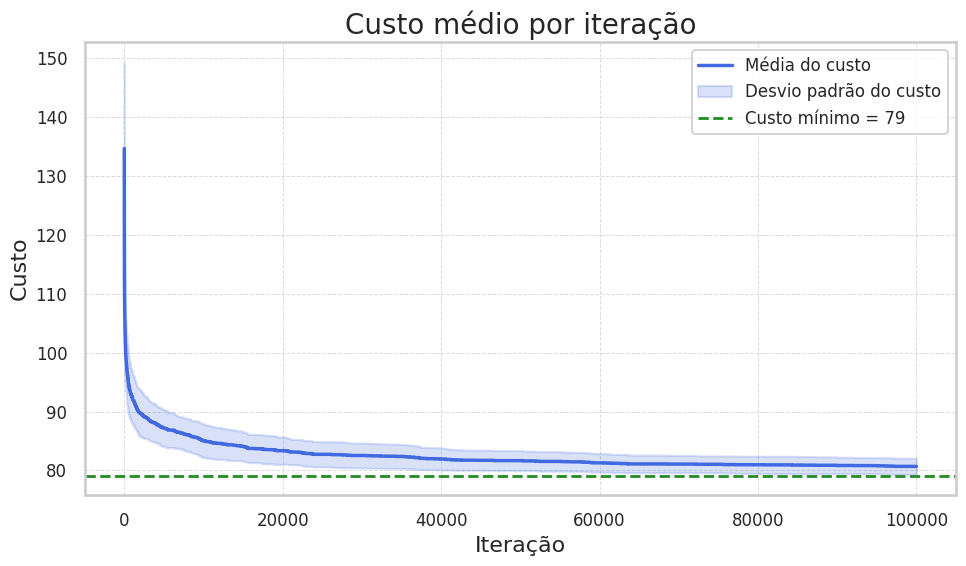

In [32]:
fig_costs, ax_costs = plt.subplots(figsize=(10, 6))

sns.lineplot(
    x=np.arange(len(means_by_iteration)),
    y=means_by_iteration,
    ax=ax_costs,
    label="Média do custo",
    color="royalblue",
    linewidth=2.5
)

ax_costs.fill_between(
    np.arange(len(means_by_iteration)),
    means_by_iteration - std_by_iteration,
    means_by_iteration + std_by_iteration,
    color="royalblue",
    alpha=0.2,
    label="Desvio padrão do custo"
)

ax_costs.axhline(
    y=min_cost,
    linestyle="--",
    color="forestgreen",
    linewidth=2,
    label=f"Custo mínimo = {min_cost}"
)

ax_costs.set_title("Custo médio por iteração", fontsize=20)
ax_costs.set_xlabel("Iteração", fontsize=16)
ax_costs.set_ylabel("Custo", fontsize=16)
ax_costs.tick_params(axis='both', which='major', labelsize=12)
ax_costs.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax_costs.legend(fontsize=12, frameon=True)
plt.tight_layout()
plt.savefig("images/mean_cost_per_iteration.svg", dpi=300)
plt.show()

## 5.2. Distribuição do tempo de execução

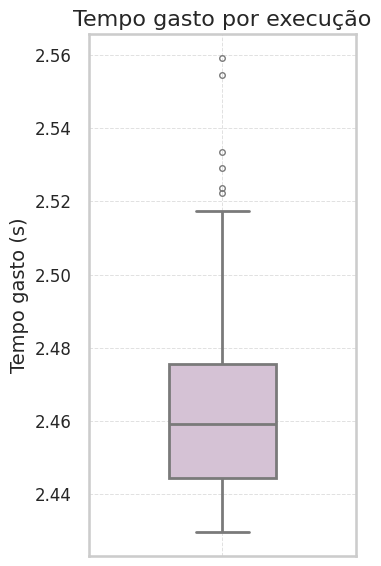

In [33]:
fig_time, ax_time = plt.subplots(figsize=(4, 6))

sns.boxplot(
    y=df["execution_time"],
    ax=ax_time,
    color="thistle",
    width=0.4,
    fliersize=4,
    linewidth=2
)

ax_time.set_title("Tempo gasto por execução", fontsize=16)
ax_time.set_ylabel("Tempo gasto (s)", fontsize=14)
ax_time.set_xlabel("")
ax_time.tick_params(axis='both', which='major', labelsize=12)
ax_time.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.savefig("images/execution_time_per_run.svg", dpi=300)
plt.show()

## 5.3. Pico de memória

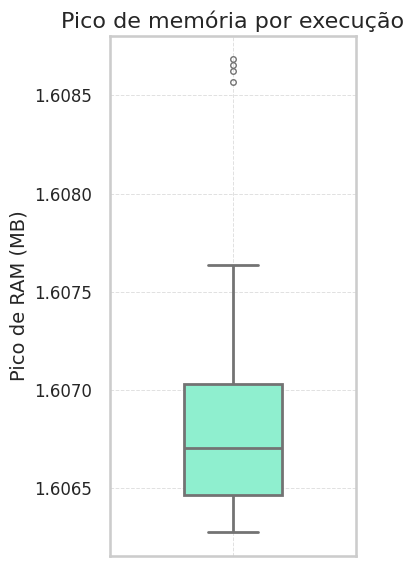

In [34]:
fig_peak, ax_peak = plt.subplots(figsize=(4, 6))

sns.boxplot(
    y=df["memory_peak_mb"],
    ax=ax_peak,
    color="aquamarine",
    width=0.4,
    fliersize=4,
    linewidth=2
)

ax_peak.set_title("Pico de memória por execução", fontsize=16)
ax_peak.set_ylabel("Pico de RAM (MB)", fontsize=14)
ax_peak.set_xlabel("")
ax_peak.tick_params(axis='both', which='major', labelsize=12)
ax_peak.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.savefig("images/memory_peak_per_run.svg", dpi=300)
plt.show()